In [ ]:
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm

from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('data\winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
def grab_col_names(df, categorical_threshold=10, cardinal_threshold=20):
    """
    Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical
    """
    categorical = [col for col in df.columns if df[col].dtype == "O"]
    Numerical_categorical = [
        col
        for col in df.columns
        if df[col].nunique() < categorical_threshold and df[col].dtype != "O"
    ]
    cardinal_cols = [
        col
        for col in df.columns
        if df[col].dtype == "O" and df[col].nunique() > cardinal_threshold
    ]
    categorical_cols = [
        col for col in (categorical + Numerical_categorical) if col not in cardinal_cols
    ]
    Numerical_cols = [
        col
        for col in df.columns
        if df[col].dtype != "O" and col not in Numerical_categorical
    ]
    print(
        f"Numerical_cols : {Numerical_cols} \n categorical_cols : {categorical_cols} \n cardinal_cols : {cardinal_cols} \n  Numerical_categorical : {Numerical_categorical}"
    )
    return Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical


def unique_df(data):

    Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical = (
        grab_col_names(data)
    )

    col_type = pd.Series("Other", index=data.columns)
    col_type.loc[Numerical_cols] = "Numerical"
    col_type.loc[categorical_cols] = "Categorical"
    col_type.loc[cardinal_cols] = "Cardinal"

    def unique_or_range(col):
        if col.name in categorical_cols or col.name in cardinal_cols:
            return col.unique()
        elif col.name in Numerical_cols:
            return f"[min,max] : [{col.min()} , {col.max()}]"
        else:
            return None

    df = pd.DataFrame(
        {
            "Type": col_type,
            "Null Values Percentage": (data.isnull().mean() * 100).round(3),
            "Number of Uniques": data.nunique(),
            "Unique Values": data.apply(unique_or_range),
        }
    ).sort_values(by=["Type", "Null Values Percentage"], ascending=[True, False])
    df = df.style.background_gradient(cmap="YlGn", axis=0).format(
        {"Null Values Percentage": "{:.2f}"}
    )
    return df


unique_df(df)

Numerical_cols : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] 
 categorical_cols : ['quality'] 
 cardinal_cols : [] 
  Numerical_categorical : ['quality']


,Type,Null Values Percentage,Number of Uniques,Unique Values
quality,Categorical,0.00,6,[5 6 7 4 8 3]
fixed acidity,Numerical,0.00,96,"[min,max] : [4.6 , 15.9]"
volatile acidity,Numerical,0.00,143,"[min,max] : [0.12 , 1.58]"
citric acid,Numerical,0.00,80,"[min,max] : [0.0 , 1.0]"
residual sugar,Numerical,0.00,91,"[min,max] : [0.9 , 15.5]"
chlorides,Numerical,0.00,153,"[min,max] : [0.012 , 0.611]"
free sulfur dioxide,Numerical,0.00,60,"[min,max] : [1.0 , 72.0]"
total sulfur dioxide,Numerical,0.00,144,"[min,max] : [6.0 , 289.0]"
density,Numerical,0.00,436,"[min,max] : [0.99007 , 1.00369]"
pH,Numerical,0.00,89,"[min,max] : [2.74 , 4.01]"


In [ ]:
def describe_cmap(data, cols=None, cmap="YlGn"):
    if cols is None:
        desc = data.describe()[1:]
        desc = desc.T.sort_values(by="std", ascending=False)
        return desc.style.background_gradient(cmap=cmap, axis=1).format("{:.2f}")
    else:
        desc = data[cols].describe(include="all")[1:]
        desc = desc.T.sort_values(by="std", ascending=False)
        return desc.style.background_gradient(cmap=cmap, axis=1).format("{:.2f}")

describe_cmap(df)

,mean,std,min,25%,50%,75%,max
fixed acidity,8.32,1.74,4.60,7.10,7.90,9.20,15.90
volatile acidity,0.53,0.18,0.12,0.39,0.52,0.64,1.58
citric acid,0.27,0.19,0.00,0.09,0.26,0.42,1.00
residual sugar,2.54,1.41,0.90,1.90,2.20,2.60,15.50
chlorides,0.09,0.05,0.01,0.07,0.08,0.09,0.61
free sulfur dioxide,15.87,10.46,1.00,7.00,14.00,21.00,72.00
total sulfur dioxide,46.47,32.90,6.00,22.00,38.00,62.00,289.00
density,1.00,0.00,0.99,1.00,1.00,1.00,1.00
pH,3.31,0.15,2.74,3.21,3.31,3.40,4.01
sulphates,0.66,0.17,0.33,0.55,0.62,0.73,2.00


In [ ]:
Numerical_cols, categorical_cols, cardinal_cols, Numerical_categorical= grab_col_names(df)

Numerical_cols : ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'] 
 categorical_cols : ['quality'] 
 cardinal_cols : [] 
  Numerical_categorical : ['quality']


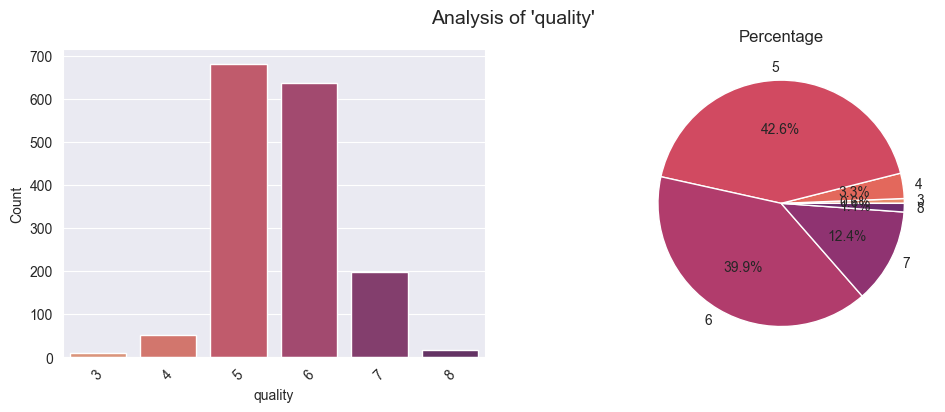

In [ ]:
def categorical_summary(df, columns: list | str, target_feature: str = None):
    if isinstance(columns, str):
        columns = [columns]

    for column in columns:
        sns.set_style("darkgrid")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        value_counts_sorted = df[column].value_counts().sort_index()
        category_order = value_counts_sorted.index
        colors = sns.color_palette("flare", len(category_order))

        if target_feature:
            sns.countplot(
                data=df,
                x=column,
                ax=axes[0],
                hue=target_feature,
                palette="flare",
                order=category_order,
            )
        else:
            sns.countplot(
                data=df, x=column, ax=axes[0], palette="flare", order=category_order
            )

        axes[0].set_ylabel("Count")
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

        axes[1].pie(
            x=value_counts_sorted.values,
            labels=category_order,
            colors=colors,
            autopct="%1.1f%%",
        )
        axes[1].set_title("Percentage")

        fig.suptitle(f"Analysis of '{column}'", fontsize=14)
        warnings.filterwarnings("ignore")
        plt.show()


categorical_summary(df=df, columns="quality")

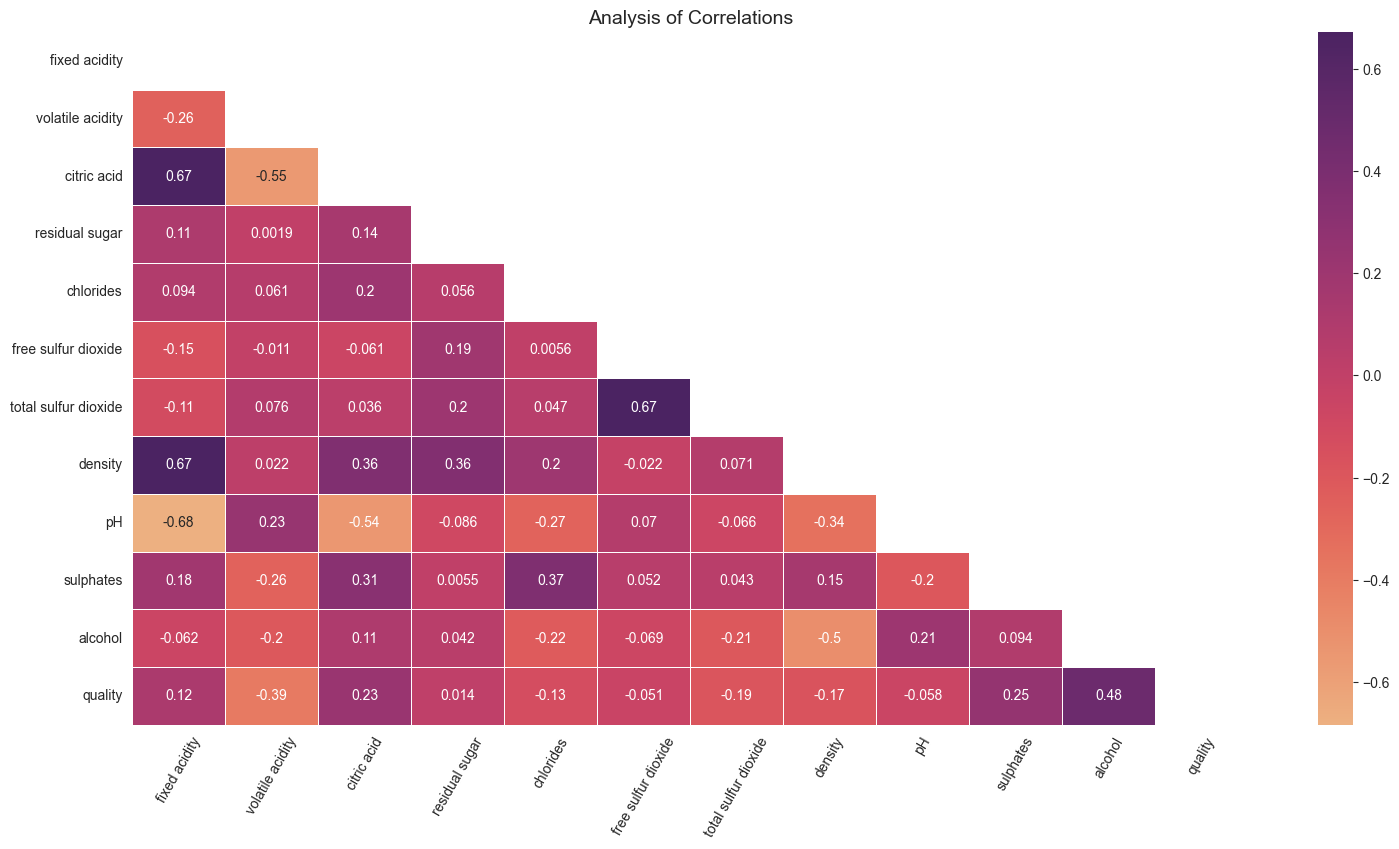

In [ ]:
def correlated_map(data, cmap="YlGn"):
    n_cols = len(data.columns.to_list())
    plt.figure(figsize=(n_cols * 1.5, n_cols * 0.75))
    sns.set_style("white")
    sns.heatmap(
        data.corr(numeric_only=True),
        cmap=cmap,
        annot=True,
        mask=np.triu(data.corr(numeric_only=True)),
        linewidths=0.6,
    )
    plt.title("Analysis of Correlations", size=14)
    plt.xticks(rotation=60, size=10)
    warnings.filterwarnings("ignore")


correlated_map(df, cmap="flare")

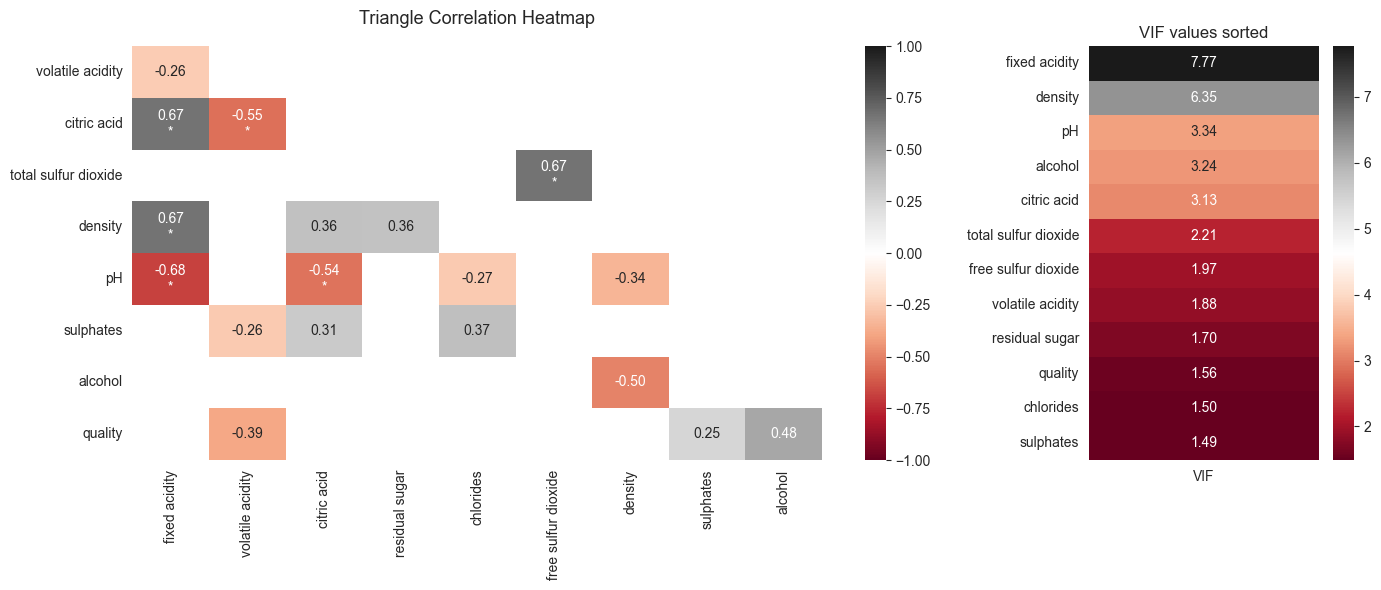

In [ ]:
def triangle_correlation(data):
    corr = data.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    mask |= np.abs(corr) < 0.25
    corr = corr[~mask]
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
    annot = [
        [
            f"{val:.2f}"
            + ("" if abs(val) < 0.5 else "\n*")
            + ("" if abs(val) < 0.75 else "*")
            + ("" if abs(val) < 0.9 else "*")
            for val in row
        ]
        for row in corr.to_numpy()
    ]

    X = add_constant(data.select_dtypes(include=["int64", "float64"]))
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X.columns
    vif_df["VIF"] = [
        variance_inflation_factor(X.values, i).round(2) for i in range(X.shape[1])
    ]
    vif_df.sort_values(by="VIF", ascending=False, inplace=True)
    vif_df = vif_df.drop(0)

    f, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [3, 1]})
    heatmap = sns.heatmap(
        corr, vmin=-1, vmax=1, annot=annot, fmt="", cmap="RdGy", ax=axes[0]
    )
    heatmap.set_title("Triangle Correlation Heatmap", fontdict={"fontsize": 13}, pad=16)

    sns.heatmap(
        vif_df[["VIF"]],
        annot=True,
        cmap="RdGy",
        cbar=True,
        yticklabels=vif_df["Feature"],
        fmt=".2f",
        ax=axes[1],
    )
    axes[1].set_title("VIF values sorted")

    plt.grid()
    plt.tight_layout()
    plt.show()


triangle_correlation(df)

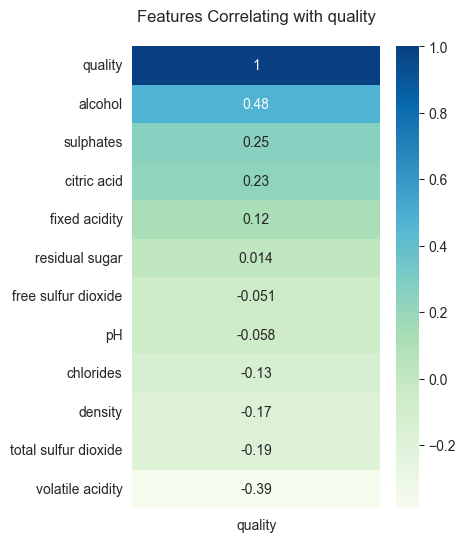

In [ ]:
def features_correlating(data, target_feature: str):
    n_cols = len(data.columns.to_list())
    plt.figure(figsize=(4, 0.5 * n_cols))
    sns.heatmap(
        data=data.corr(numeric_only=True)[[target_feature]].sort_values(
            by=target_feature, ascending=False
        ),
        cmap="YlGn",
        annot=True,
    )
    plt.title(f"Features Correlating with {target_feature}", pad=18)

features_correlating(data=df,target_feature='quality')

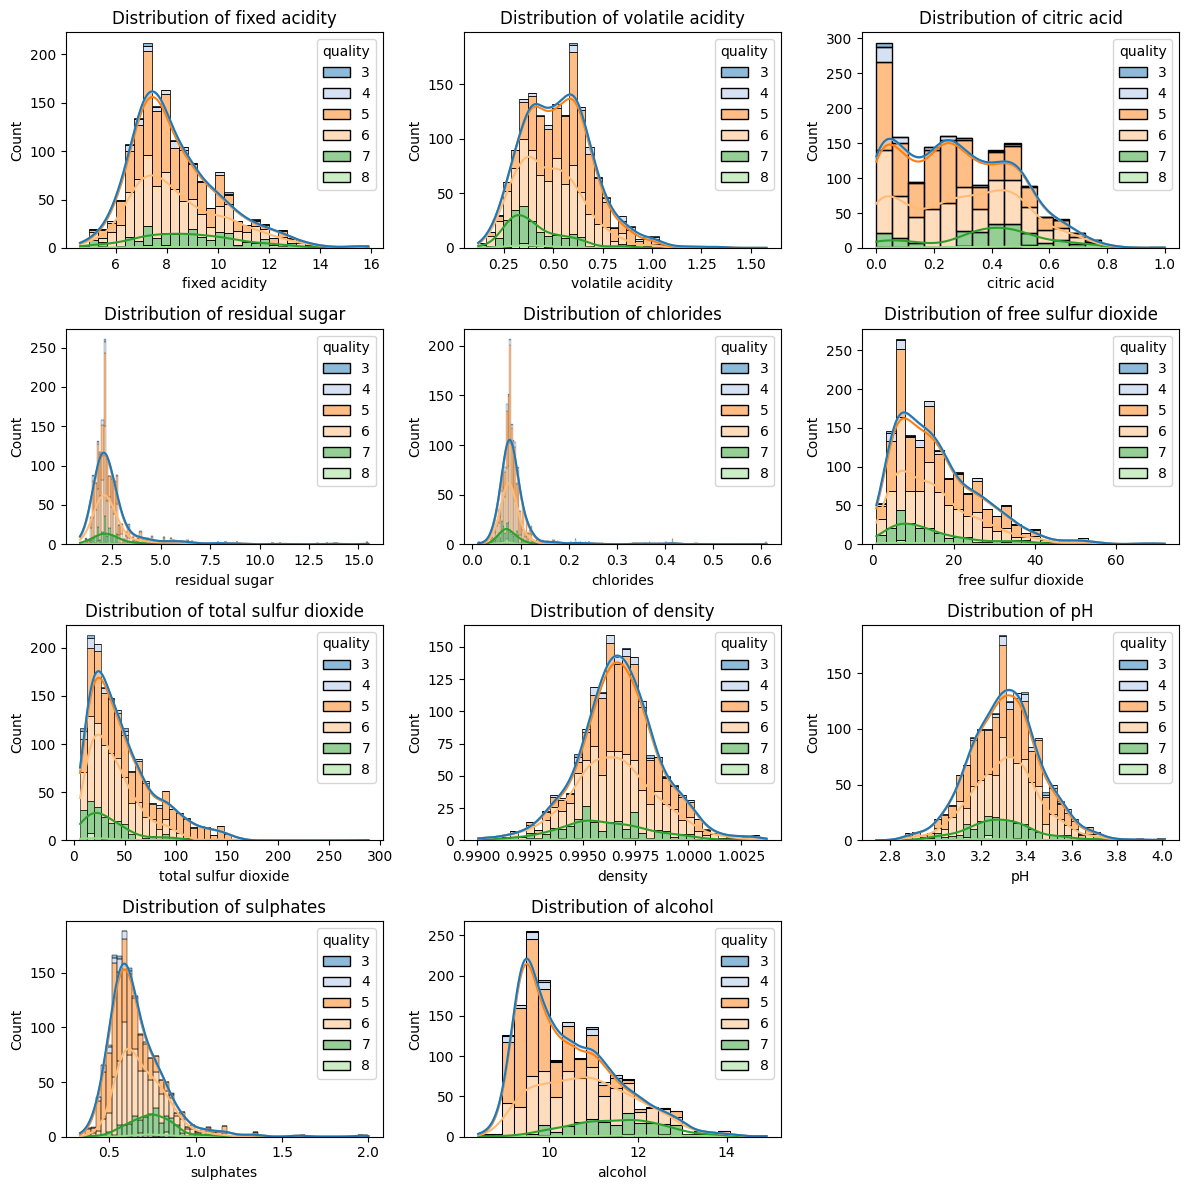

In [ ]:
def plot_hist_kde(df, columns: list, exclude=None, multiple: str = "layer", hue=None):
    columns = [col for col in columns if col != exclude]

    n_cols = 3
    num_plots = len(columns)
    n_rows = math.ceil(num_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    if isinstance(hue, str):
        for i, col in enumerate(columns):
            sns.histplot(
                data=df,
                x=col,
                kde=True,
                ax=axes[i],
                multiple=multiple,
                hue=hue,
                palette=sns.color_palette("tab20"),
            )
            axes[i].set_title(f"Distribution of {col}")
    else:
        for i, col in enumerate(columns):
            sns.histplot(
                x=df[col],
                kde=True,
                ax=axes[i],
                multiple=multiple,
                palette=sns.color_palette("tab20"),
            )
            axes[i].set_title(f"Distribution of {col}")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_hist_kde(df=df, columns=Numerical_cols, multiple="stack", hue="quality")

In [ ]:
def outlier_counter_iqr(data, min_out, Q1=0.25, Q3=0.75):
    """
    Outliers Conuter By IQR method and Return Outliers Indexes
    """
    outliers = []
    for col in data.columns:
        Q1_val = data[col].quantile(Q1)
        Q3_val = data[col].quantile(Q3)
        IQR = Q3_val - Q1_val
        lower_bound = Q1_val - 1.5 * IQR
        upper_bound = Q3_val + 1.5 * IQR

        mask = (data[col] < lower_bound) | (data[col] > upper_bound)
        outlier_idx = data.index[mask]
        outliers.extend(outlier_idx)
        print(f"{col} : {len(outlier_idx)} outliers")

    from collections import Counter

    outlier_counts = Counter(outliers)
    OUTs = [idx for idx, count in outlier_counts.items() if count >= min_out]
    print("\nTotal number of outliers is:", len(OUTs))

    return OUTs


outlier_counter_iqr(df, min_out=2)

Total number of outliers is: 37


[353,
 364,
 366,
 374,
 440,
 442,
 538,
 554,
 555,
 557,
 559,
 564,
 652,
 690,
 1299,
 151,
 14,
 15,
 396,
 400,
 415,
 515,
 1114,
 1244,
 1358,
 1434,
 1435,
 1474,
 1476,
 1558,
 614,
 695,
 1319,
 588,
 821,
 1269,
 1270]

<a id="ml"></a>

<h1 style="
    background-size: cover;
    background-position: center;
    background-color: #a159bdff;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    Modeling
</h1>


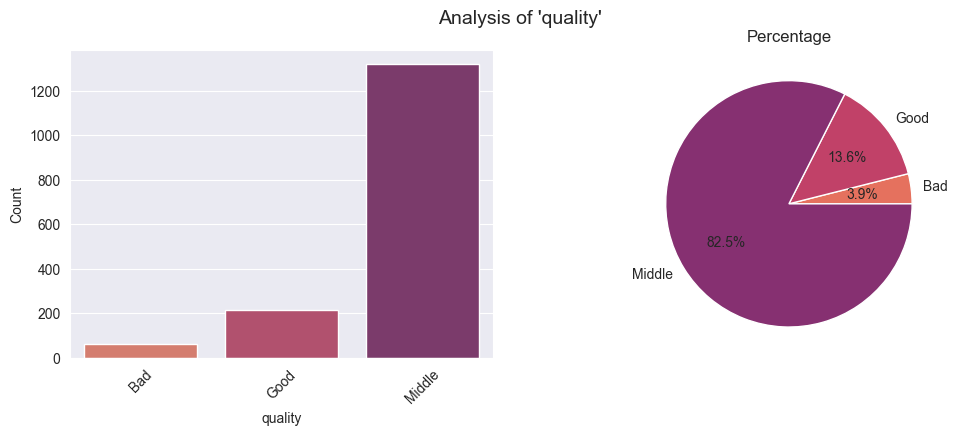

In [ ]:
df2 = df.replace(
    {"quality": {8: "Good", 7: "Good", 6: "Middle", 5: "Middle", 4: "Bad", 3: "Bad"}}
)
categorical_summary(df2,columns='quality')

In [6]:
df3 = df2.copy()
labelencoder = LabelEncoder()
df3['quality'] = labelencoder.fit_transform(df3['quality'])

<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    Logistic Regression
</h1>


In [ ]:
def model_fitter(
    model_name: str,
    model_obj,
    data,
    model_data_splits: dict,
    target_feature: str,
    test_size=0.2,
    standardScaler=False,
    stratify=False,
    Smote=False,
):
    X = data.drop(target_feature, axis=1)
    y = data[target_feature]

    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=0, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=0
        )

    if standardScaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if Smote:
        print("Before SMOTE:")
        print(y_train.value_counts(normalize=True), "\n")
        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        print("After SMOTE:")
        print(pd.Series(y_train_smote).value_counts(normalize=True), "\n")
        model_obj.fit(X_train_smote, y_train_smote)
    else:
        X_train_smote, y_train_smote = None, None
        model_obj.fit(X_train, y_train)

    model_data_splits[model_name] = {
        "model_obj": model_obj,
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred_prob": model_obj.predict_proba(X_test),
        "Features": data.columns.drop(target_feature).to_list(),
        "X_train_smote": X_train_smote,
        "y_train_smote": y_train_smote,
    }

    def info_shape(**kwargs):
        for name, arr in kwargs.items():
            print(f"{name}: {arr.shape}")

    info_shape(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

    print(f"The Name of Fitted Model : {model_name} \n")
    return model_obj

In [ ]:
model_data_splits = {}
LG_unSMOTE = model_fitter(
    model_name="LG_unSMOTE",
    model_obj=LogisticRegression(
        C=1.2, fit_intercept=True, penalty="l1", solver="saga"
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)
LG_unSMOTE_balanced = model_fitter(
    model_name="LG_unSMOTE_balanced",
    model_obj=LogisticRegression(
        C=1.2, fit_intercept=True, penalty="l1", solver="saga", class_weight="balanced"
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)
LG_SMOTE = model_fitter(
    model_name="LG_SMOTE",
    model_obj=LogisticRegression(
        C=1.2, fit_intercept=True, penalty="l1", solver="saga"
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    Smote=True,
    stratify=True,
)

X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LG_unSMOTE 

X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LG_unSMOTE_balanced 

Before SMOTE:
quality
2    0.824863
1    0.136044
0    0.039093
Name: proportion, dtype: float64 

After SMOTE:
quality
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64 

X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LG_SMOTE 



In [ ]:
def metrics_calculator(y_test, y_pred_test, model, model_name, X_test, ovr):
    if len(set(y_test)) == 2:
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.predict_proba(X_test)

    if ovr:
        metrics = {
            "F1-score": f1_score(y_test, y_pred_test, average="macro"),
            "Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average="macro"),
            "Recall": recall_score(y_test, y_pred_test, average="macro"),
            "roc_auc_score": roc_auc_score(y_test, y_score, multi_class="ovr"),
        }

        return pd.DataFrame(metrics, index=[model_name])
    else:
        metrics = {
            "F1-score": f1_score(y_test, y_pred_test, average="binary"),
            "Accuracy": accuracy_score(y_test, y_pred_test),
            "Precision": precision_score(y_test, y_pred_test, average="binary"),
            "Recall": recall_score(y_test, y_pred_test, average="binary"),
            "roc_auc_score": roc_auc_score(y_test, y_score),
        }

        return pd.DataFrame(metrics, index=[model_name])


def evaluate_classfications_model(
    model_names,
    model_data_splits: dict,
    confusionMatrixDisplay=True,
    classifi_report=True,
    multi_class=False,
    ROC_curve=True,
    Permutation_importance=True,
):
    model_names = model_names if isinstance(model_names, list) else [model_names]

    if confusionMatrixDisplay:
        import math

        cols = 3
        rows = math.ceil(len(model_names) / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
        axes = axes.flatten()

        for i, model_name in enumerate(model_names):
            if model_name not in model_data_splits:
                raise ValueError(
                    f"❌ Model not found in model_data_splits: {model_name}"
                )

            data = model_data_splits[model_name]
            model_obj = data["model_obj"]
            X_test = data["X_test"]
            y_test = data["y_test"]

            ConfusionMatrixDisplay.from_estimator(
                estimator=model_obj,
                X=X_test,
                y=y_test,
                colorbar=False,
                cmap="GnBu",
                ax=axes[i],
            )
            axes[i].grid(False)
            axes[i].set_title(f"Confusion Matrix of {model_name}")

        for j in range(i + 1, rows * cols):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    if ROC_curve:
        if multi_class:
            for model_name in model_names:
                if model_name not in model_data_splits:
                    raise ValueError(
                        f"❌ Model not found in model_data_splits: {model_name}"
                    )

                datas = model_data_splits[model_name]
                y_test = datas["y_test"]
                y_pred_prob = datas["y_pred_prob"]

                lb = LabelBinarizer()
                y_test_bin = lb.fit_transform(y_test)
                n_classes = y_test_bin.shape[1]

                colors = plt.cm.get_cmap("tab10", n_classes)

                plt.figure(figsize=(8, 6))
                for j in range(n_classes):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_pred_prob[:, j])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(
                        fpr,
                        tpr,
                        label=f"Class {j+1} (AUC = {roc_auc:.2f})",
                        color=colors(j),
                        lw=2,
                    )

                plt.plot([0, 1], [0, 1], "k--", lw=1)
                plt.xlabel("False Positive Rate", fontsize=12)
                plt.ylabel("True Positive Rate", fontsize=12)
                plt.title(f"ROC Curves for {model_name}", fontsize=16)
                plt.legend(loc="lower right")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

        else:
            size = len(model_names)
            cols = 2
            rows = (size + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
            axes = axes.flatten()

            for i, model_name in enumerate(model_names):
                if model_name not in model_data_splits:
                    raise ValueError(
                        f"❌ Model not found in model_data_splits: {model_name}"
                    )

                datas = model_data_splits[model_name]
                y_test = datas["y_test"]
                y_pred_prob = datas["y_pred_prob"]

                fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
                roc_auc = auc(fpr, tpr)
                axes[i].plot(
                    fpr,
                    tpr,
                    label=f"Model {model_name} (AUC = {roc_auc:.2f})",
                    color="red",
                )
                axes[i].set_xlabel("False Positive Rate", fontsize=12)
                axes[i].set_ylabel("True Positive Rate", fontsize=12)
                axes[i].set_title(f"ROC Curve for {model_name}", fontsize=14)
                axes[i].legend()

            for j in range(i + 1, rows * cols):
                fig.delaxes(axes[j])

            plt.tight_layout()
            plt.show()

    if Permutation_importance:
        for model_name in model_names:
            if model_name not in model_data_splits:
                raise ValueError(
                    f"❌ Model not found in model_data_splits: {model_name}"
                )

            datas = model_data_splits[model_name]
            y_test = datas["y_test"]
            x_test = datas["X_test"]
            feature_names = datas["Features"]
            model_obj = datas["model_obj"]

            perm_importance = permutation_importance(
                model_obj, x_test, y_test, n_repeats=30, random_state=42
            )
            feature_importance = perm_importance.importances_mean

            plt.figure(figsize=(12, 6))
            plt.barh(feature_names, feature_importance, color="#b40000")
            plt.xlabel("Permutation Importance")
            plt.ylabel("Feature")
            plt.title(f"Permutation Importance of Model : {model_name}")
            plt.show()

    y_pred_test = {}
    metrics = {}
    for model_name in model_names:
        data = model_data_splits[model_name]
        model_obj = data["model_obj"]
        X_test = data["X_test"]
        y_test = data["y_test"]

        y_pred = model_obj.predict(X_test)
        y_pred_test[model_name] = y_pred

        print(f"\n=== {model_name} ===")
        if classifi_report:
            print(classification_report(y_test, y_pred))

        if multi_class:
            metrics[model_name] = metrics_calculator(
                y_test, y_pred, model_obj, model_name, X_test, ovr=True
            )
        else:
            metrics[model_name] = metrics_calculator(
                y_test, y_pred, model_obj, model_name, X_test, ovr=False
            )

    final_result = pd.concat(metrics.values(), axis=0).round(2)
    final_result = final_result.sort_values(by="F1-score", ascending=False)
    styled_result = final_result.style.background_gradient(cmap="YlGn", axis=0).format(
        "{:.2f}"
    )
    print("\n🎯 Final Comparison of Models:")
    return styled_result

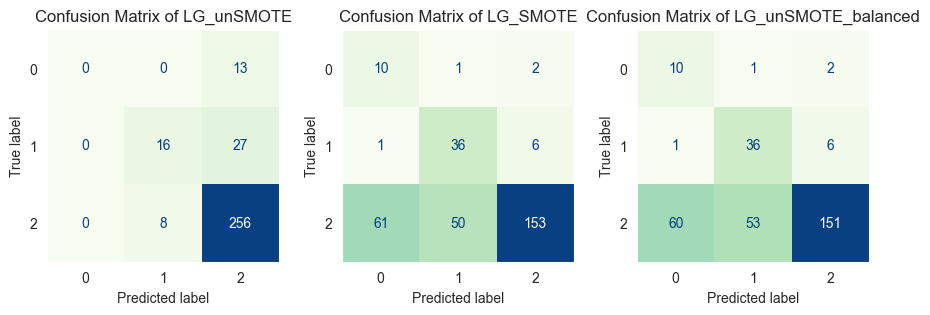

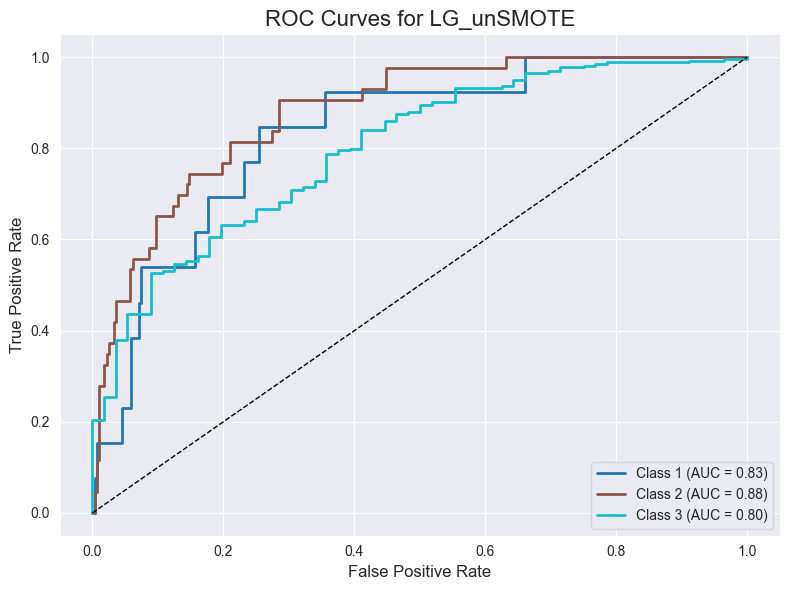

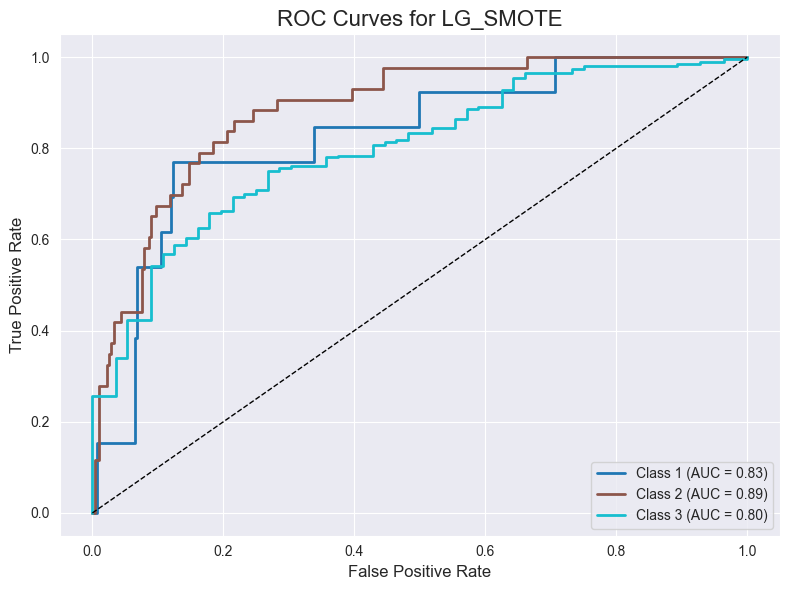

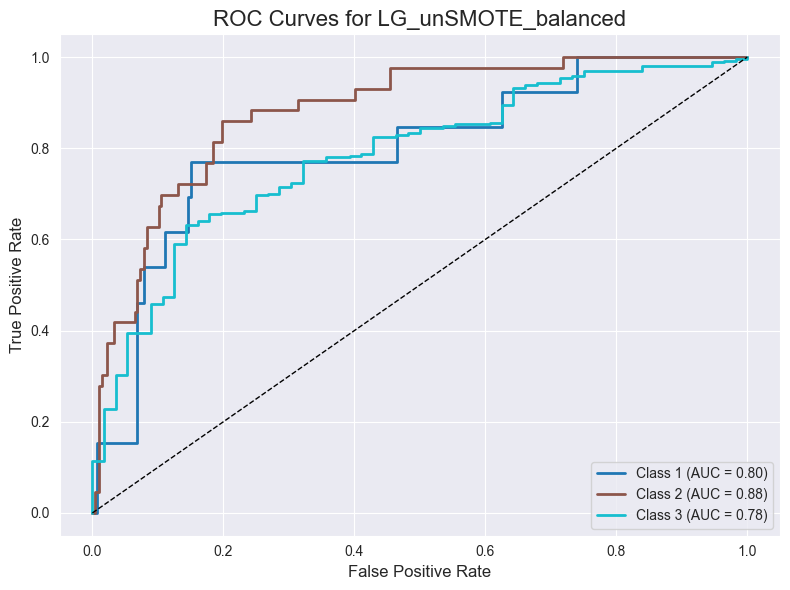

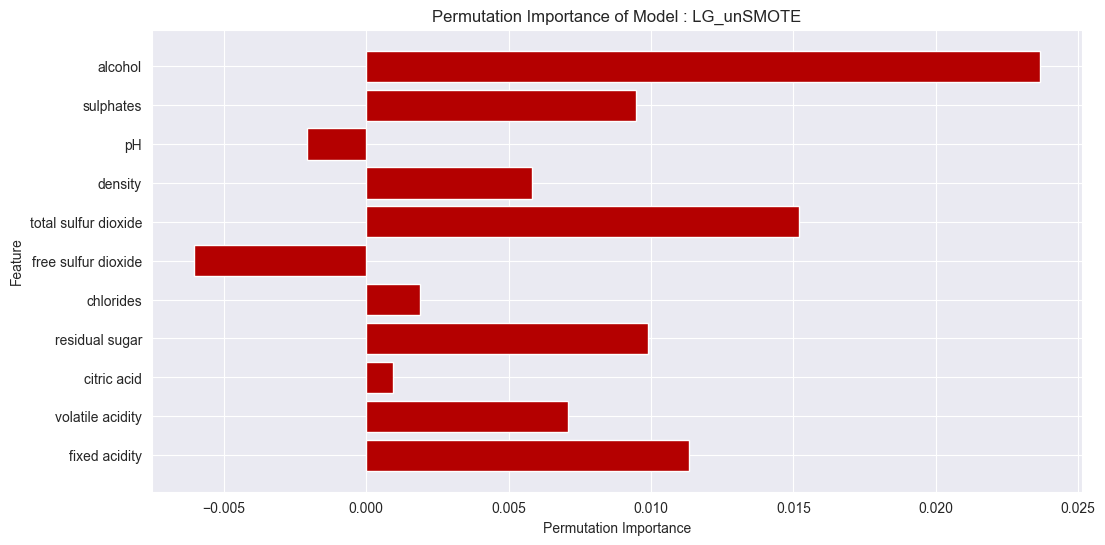

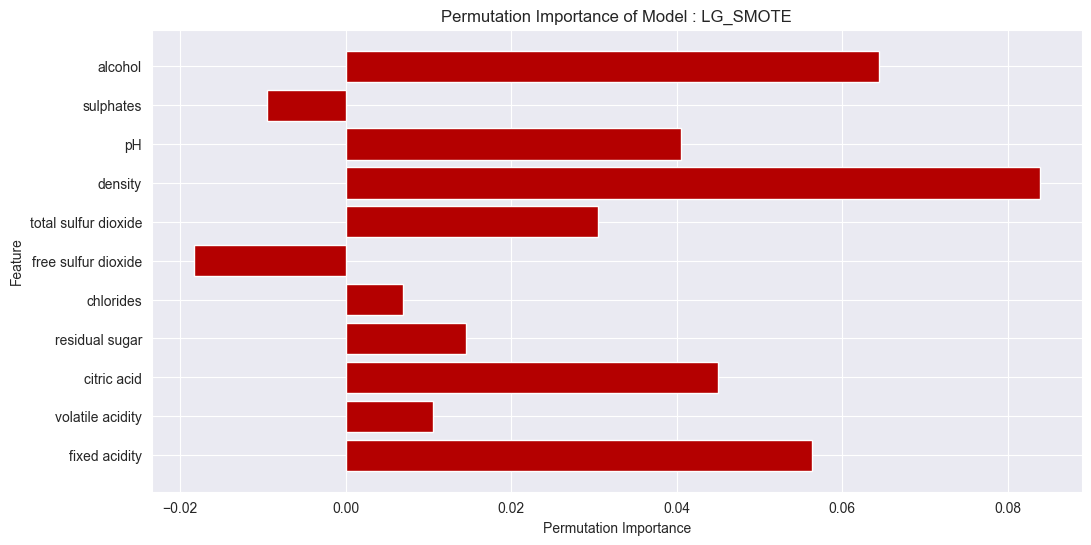

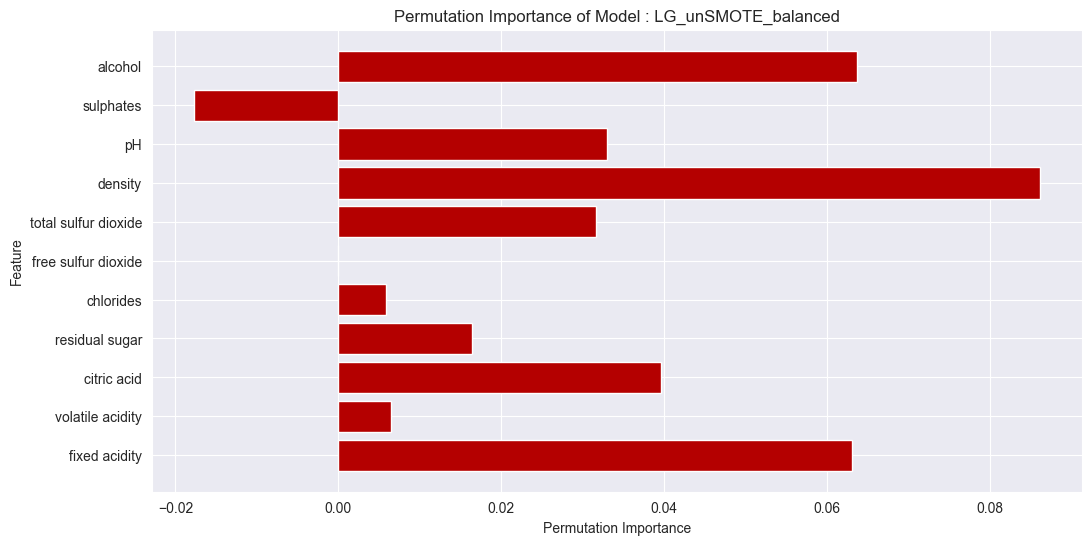


=== LG_unSMOTE ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.67      0.37      0.48        43
           2       0.86      0.97      0.91       264

    accuracy                           0.85       320
   macro avg       0.51      0.45      0.46       320
weighted avg       0.80      0.85      0.82       320


=== LG_SMOTE ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.41      0.84      0.55        43
           2       0.95      0.58      0.72       264

    accuracy                           0.62       320
   macro avg       0.50      0.73      0.50       320
weighted avg       0.85      0.62      0.68       320


=== LG_unSMOTE_balanced ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.40      0.84      0.54        43
        

,F1-score,Accuracy,Precision,Recall,roc_auc_score
LG_SMOTE,0.50,0.62,0.50,0.73,0.84
LG_unSMOTE_balanced,0.50,0.62,0.50,0.73,0.82
LG_unSMOTE,0.46,0.85,0.51,0.45,0.84


In [ ]:
evaluate_classfications_model(
    model_names=["LG_unSMOTE", "LG_SMOTE", "LG_unSMOTE_balanced"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

In [ ]:
def grid_fitter(
    model_name,
    estimator,
    param_grid,
    data,
    target_feature,
    model_data_splits: dict,
    test_size=0.2,
    standardScaler=False,
    scoring="accuracy",
):
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(target_feature, axis=1),
        data[target_feature],
        test_size=test_size,
        random_state=0,
    )

    if standardScaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    gridcv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    ).fit(X_train, y_train)

    BestGrid_model = gridcv.best_estimator_

    model_data_splits[model_name] = {
        "model_obj": BestGrid_model,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }

    print("Best Score is: %s" % gridcv.best_score_)
    print("Best Hyperparameters are: %s" % gridcv.best_params_)
    return BestGrid_model

In [ ]:
param_grid_LG = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["saga"],
    "class_weight": [None, "balanced"],
    "max_iter": [100, 200, 300],
}

LG_grid = grid_fitter(
    model_name="LG_grid",
    estimator=LogisticRegression(class_weight="balanced"),
    param_grid=param_grid_LG,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

Best Score is: 0.4970045957418475
Best Hyperparameters are: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
evaluate_classfications_model(
    model_names=["LG_unSMOTE", "LG_SMOTE", "LG_unSMOTE_balanced", "LG_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)


=== LG_unSMOTE ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.67      0.37      0.48        43
           2       0.86      0.97      0.91       264

    accuracy                           0.85       320
   macro avg       0.51      0.45      0.46       320
weighted avg       0.80      0.85      0.82       320


=== LG_SMOTE ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.41      0.84      0.55        43
           2       0.95      0.58      0.72       264

    accuracy                           0.62       320
   macro avg       0.50      0.73      0.50       320
weighted avg       0.85      0.62      0.68       320


=== LG_unSMOTE_balanced ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.40      0.84      0.54        43
        

,F1-score,Accuracy,Precision,Recall,roc_auc_score
LG_SMOTE,0.50,0.62,0.50,0.73,0.84
LG_unSMOTE_balanced,0.50,0.62,0.50,0.73,0.82
LG_unSMOTE,0.46,0.85,0.51,0.45,0.84
LG_grid,0.45,0.86,0.45,0.45,0.80


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    Decision Tree
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : DT_unBalanced 



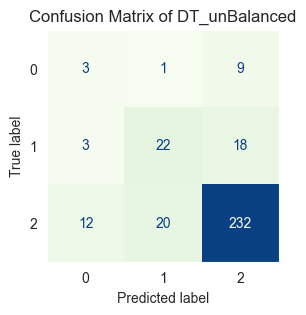

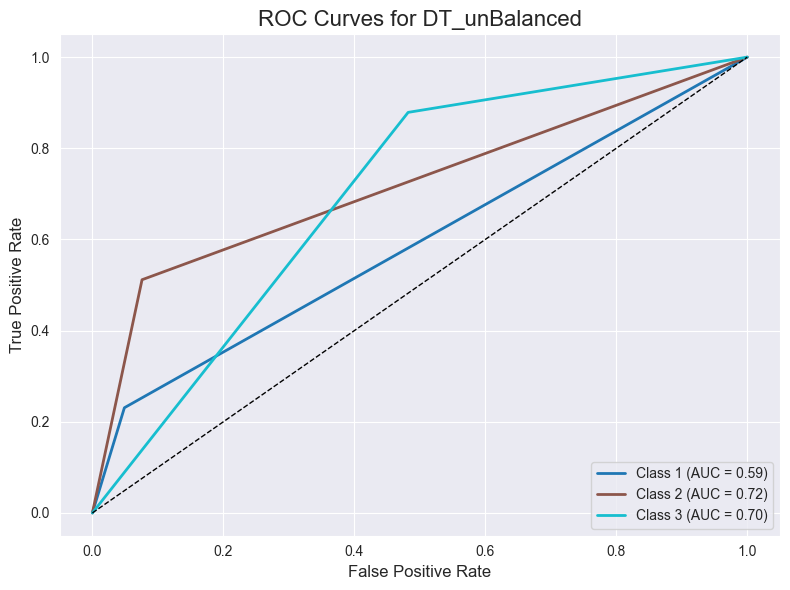

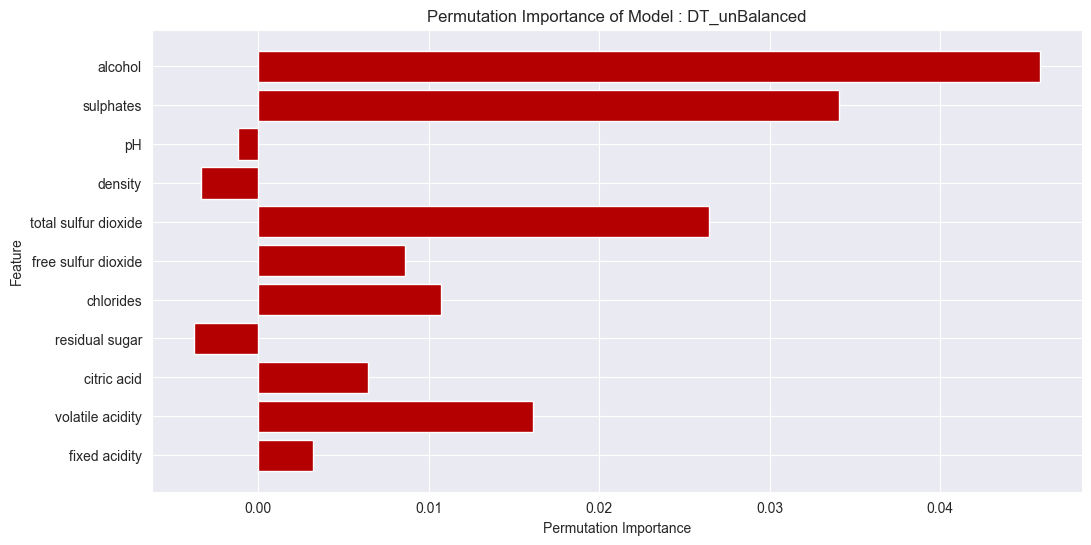


=== DT_unBalanced ===
              precision    recall  f1-score   support

           0       0.17      0.23      0.19        13
           1       0.51      0.51      0.51        43
           2       0.90      0.88      0.89       264

    accuracy                           0.80       320
   macro avg       0.52      0.54      0.53       320
weighted avg       0.81      0.80      0.81       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
DT_unBalanced,0.53,0.80,0.52,0.54,0.67


In [ ]:
DT_unBalanced = model_fitter(
    model_name="DT_unBalanced",
    model_obj=DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_features=6,
        max_depth=20,
        max_leaf_nodes=200,
        random_state=33,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["DT_unBalanced"], model_data_splits=model_data_splits, multi_class=True
)

In [ ]:
param_grid_DT = {
    "criterion": ["gini", "entropy"],   
    "max_depth": [3, 5, 10, 15, None],   
    "min_samples_split": [2, 5, 10],   
    "min_samples_leaf": [1, 2, 4, 6],  
    "class_weight": [None, "balanced"],  
    "max_features": [None, "sqrt", "log2"], 
}


DT_grid = grid_fitter(
    model_name="DT_grid",
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid_DT,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

evaluate_classfications_model(
    model_names=["DT_unBalanced", "DT_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)

Best Score is: 0.8428553921568627
Best Hyperparameters are: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10}



=== DT_unBalanced ===
              precision    recall  f1-score   support

           0       0.17      0.23      0.19        13
           1       0.51      0.51      0.51        43
           2       0.90      0.88      0.89       264

    accuracy                           0.80       320
   macro avg       0.52      0.54      0.53       320
weighted avg       0.81      0.80      0.81       320


=== DT_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.39      0.30      0.34        30
           2       0.89      0.95      0.92       277

    accuracy                           0.85       320
   macro avg       0.43      0.42      0.42       320
weighted avg       0.80      0.85      0.83       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
DT_unBalanced,0.53,0.80,0.52,0.54,0.67
DT_grid,0.42,0.85,0.43,0.42,0.74


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    RandomForestClassifier
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : RF_unBalanced 

X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : RF_Balanced 



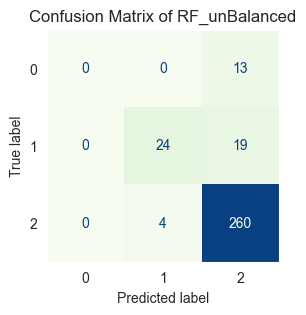

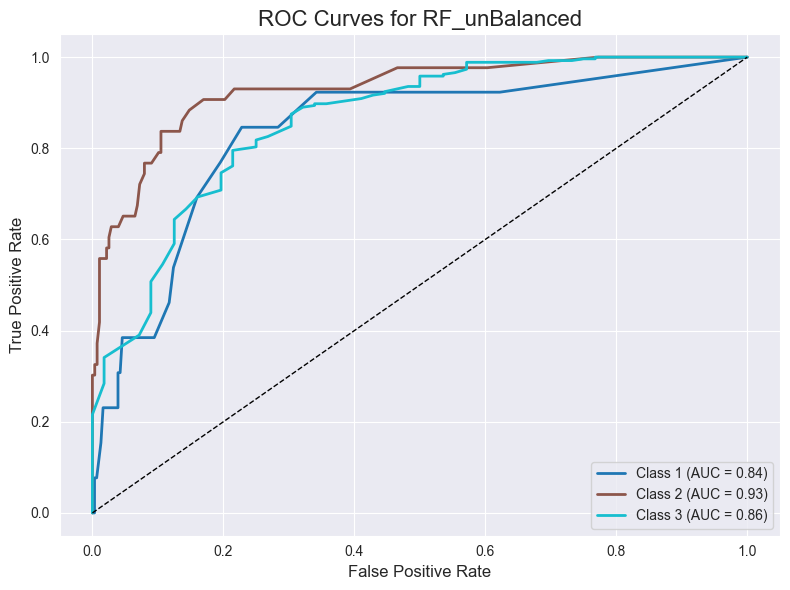

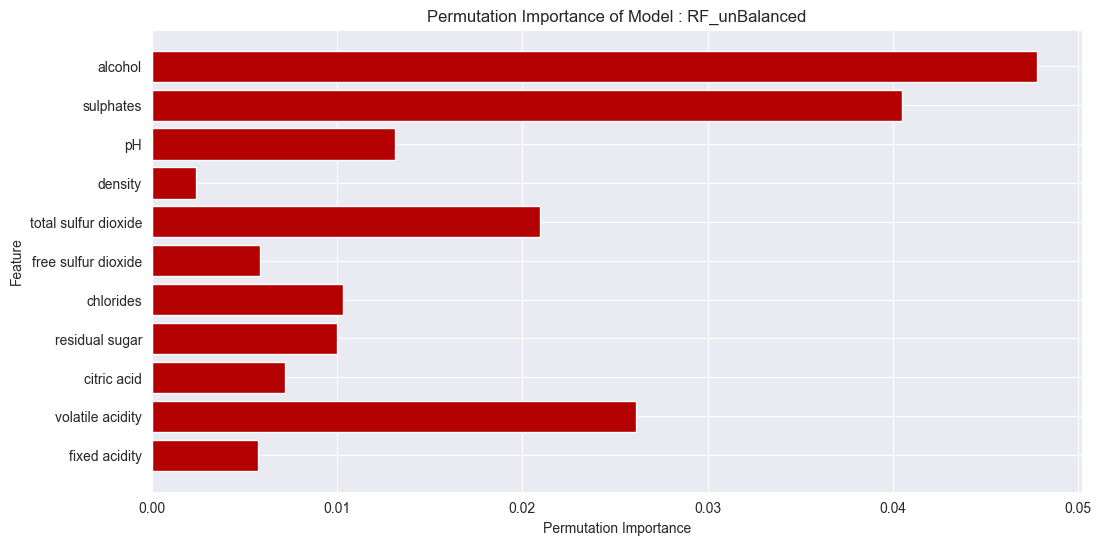


=== RF_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.86      0.56      0.68        43
           2       0.89      0.98      0.94       264

    accuracy                           0.89       320
   macro avg       0.58      0.51      0.54       320
weighted avg       0.85      0.89      0.86       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
RF_unBalanced,0.54,0.89,0.58,0.51,0.87


In [ ]:
RF_unBalanced = model_fitter(
    model_name="RF_unBalanced",
    model_obj=RandomForestClassifier(
        criterion="gini",
        max_depth=30,
        max_features="sqrt",
        n_estimators=100,
        random_state=33,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)
RF_Balanced = model_fitter(
    model_name="RF_Balanced",
    model_obj=RandomForestClassifier(
        class_weight='balanced',
        criterion="gini",
        max_depth=30,
        max_features="sqrt",
        n_estimators=100,
        random_state=33,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["RF_unBalanced"], model_data_splits=model_data_splits, multi_class=True
)

In [ ]:
param_grid_RF =  {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}


RF_grid = grid_fitter(
    model_name="RF_grid",
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_RF,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

evaluate_classfications_model(
    model_names=["RF_unBalanced", "RF_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)

Best Score is: 0.6078283592250763
Best Hyperparameters are: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

=== RF_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.86      0.56      0.68        43
           2       0.89      0.98      0.94       264

    accuracy                           0.89       320
   macro avg       0.58      0.51      0.54       320
weighted avg       0.85      0.89      0.86       320


=== RF_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.44      0.77      0.56        30
           2       0.92      0.88      0.90       277

    accuracy                           0.84       320
   macro avg       0.46      0.55      0.49       320
weighted avg       0.84      0.84      0.84 

,F1-score,Accuracy,Precision,Recall,roc_auc_score
RF_unBalanced,0.54,0.89,0.58,0.51,0.87
RF_grid,0.49,0.84,0.46,0.55,0.87


In [ ]:
evaluate_classfications_model(
    model_names=["RF_unBalanced", "RF_grid",'RF_Balanced'],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)


=== RF_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.86      0.56      0.68        43
           2       0.89      0.98      0.94       264

    accuracy                           0.89       320
   macro avg       0.58      0.51      0.54       320
weighted avg       0.85      0.89      0.86       320


=== RF_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.44      0.77      0.56        30
           2       0.92      0.88      0.90       277

    accuracy                           0.84       320
   macro avg       0.46      0.55      0.49       320
weighted avg       0.84      0.84      0.84       320


=== RF_Balanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.78      0.49      0.60        43
           2  

,F1-score,Accuracy,Precision,Recall,roc_auc_score
RF_unBalanced,0.54,0.89,0.58,0.51,0.87
RF_Balanced,0.51,0.87,0.55,0.49,0.85
RF_grid,0.49,0.84,0.46,0.55,0.87


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    SVC
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : SVC_unBalanced 



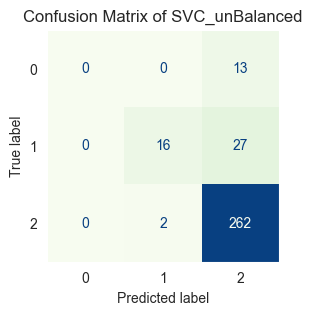

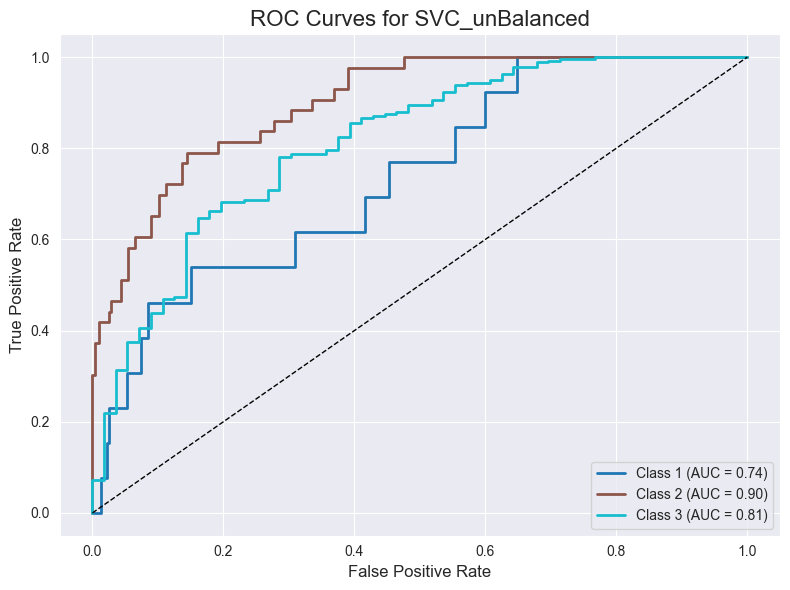

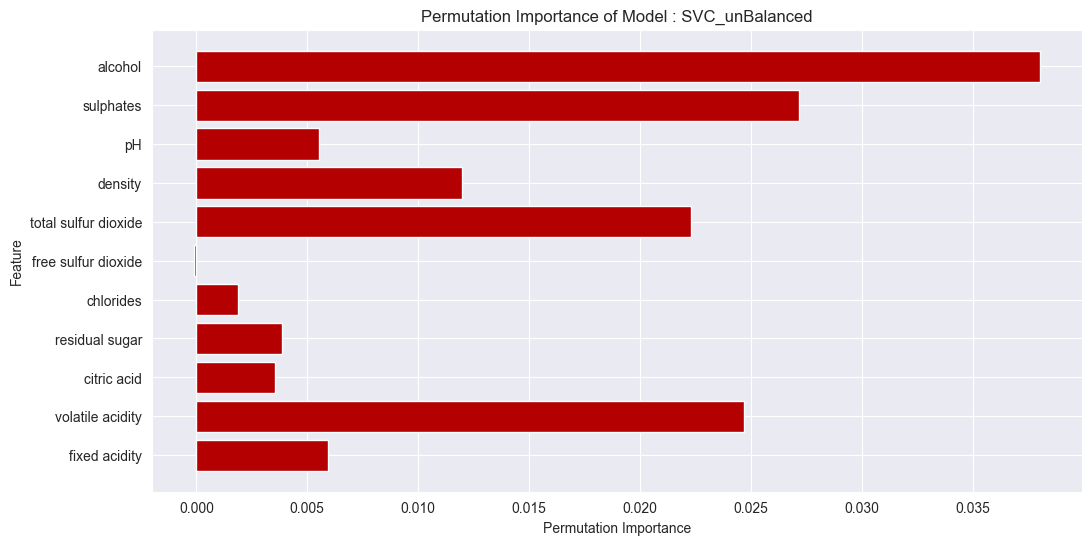


=== SVC_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.89      0.37      0.52        43
           2       0.87      0.99      0.93       264

    accuracy                           0.87       320
   macro avg       0.59      0.45      0.48       320
weighted avg       0.84      0.87      0.83       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
SVC_unBalanced,0.48,0.87,0.59,0.45,0.82


In [ ]:
SVC_unBalanced = model_fitter(
    model_name="SVC_unBalanced",
    model_obj=SVC(C=1, gamma="auto", kernel="rbf", random_state=33, probability=True),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["SVC_unBalanced"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

In [ ]:
param_grid_SVC = {
    "C": [0.1, 1, 10, 100],  
    "kernel": ["linear", "rbf"],   
    "gamma": ["scale", "auto"],  
    "class_weight": [None, "balanced"],  
}


SVC_grid = grid_fitter(
    model_name="SVC_grid",
    estimator=SVC(probability=True),
    param_grid=param_grid_SVC,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

evaluate_classfications_model(
    model_names=["SVC_unBalanced", "SVC_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)

Best Score is: 0.5660709973606748
Best Hyperparameters are: {'C': 100, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

=== SVC_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.89      0.37      0.52        43
           2       0.87      0.99      0.93       264

    accuracy                           0.87       320
   macro avg       0.59      0.45      0.48       320
weighted avg       0.84      0.87      0.83       320


=== SVC_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.50      0.70      0.58        30
           2       0.92      0.91      0.92       277

    accuracy                           0.85       320
   macro avg       0.47      0.54      0.50       320
weighted avg       0.85      0.85      0.85       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
SVC_grid,0.50,0.85,0.47,0.54,0.79
SVC_unBalanced,0.48,0.87,0.59,0.45,0.82


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    KNeighborsClassifier
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : KNN_unBalanced 



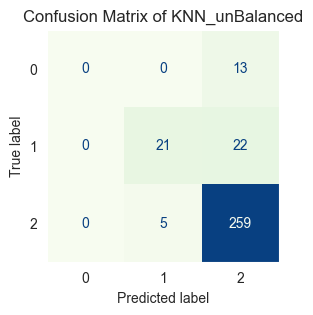

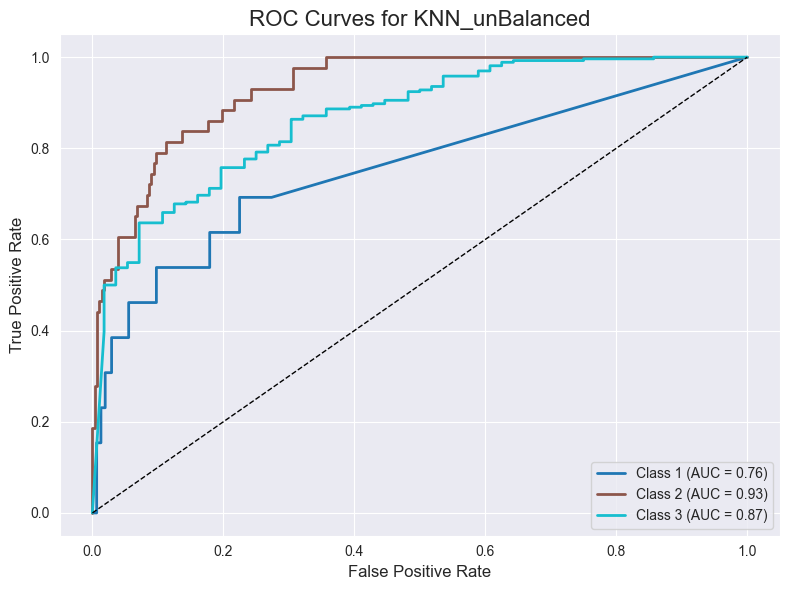

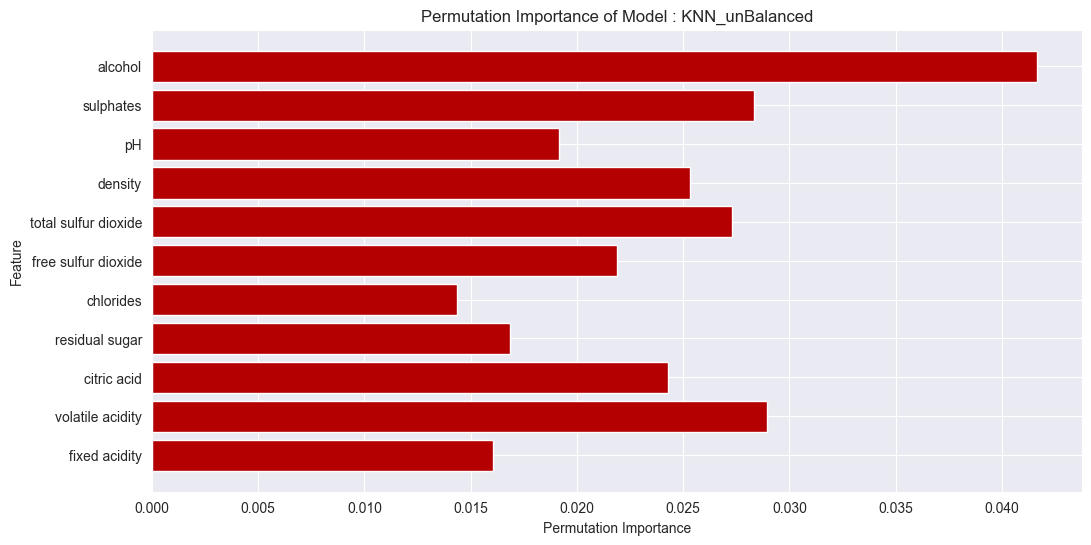


=== KNN_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.81      0.49      0.61        43
           2       0.88      0.98      0.93       264

    accuracy                           0.88       320
   macro avg       0.56      0.49      0.51       320
weighted avg       0.84      0.88      0.85       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
KNN_unBalanced,0.51,0.88,0.56,0.49,0.85


In [ ]:
KNN_unBalanced = model_fitter(
    model_name="KNN_unBalanced",
    model_obj=KNeighborsClassifier(
        algorithm="auto",
        leaf_size=20,
        metric="euclidean",
        n_jobs=-1,
        n_neighbors=25,
        p=2,
        weights="distance",
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["KNN_unBalanced"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

In [ ]:
param_grid_KNN = {
    "n_neighbors": [3, 5, 7, 11, 15],
    "weights": ["uniform", "distance"], 
    "metric": ["euclidean", "manhattan"], 
    "leaf_size": [20, 30, 50],  
    "p": [1, 2],   
}


KNN_grid = grid_fitter(
    model_name="KNN_grid",
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_KNN,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

evaluate_classfications_model(
    model_names=["KNN_unBalanced", "KNN_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)

Best Score is: 0.5637009571045919
Best Hyperparameters are: {'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

=== KNN_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.81      0.49      0.61        43
           2       0.88      0.98      0.93       264

    accuracy                           0.88       320
   macro avg       0.56      0.49      0.51       320
weighted avg       0.84      0.88      0.85       320


=== KNN_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.57      0.77      0.66        30
           2       0.93      0.94      0.93       277

    accuracy                           0.88       320
   macro avg       0.50      0.57      0.53       320
weighted avg       0.86      0.88      0.87       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
KNN_grid,0.53,0.88,0.50,0.57,0.78
KNN_unBalanced,0.51,0.88,0.56,0.49,0.85


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
Gradient Boosting Classifier
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : GBC_unBalanced 



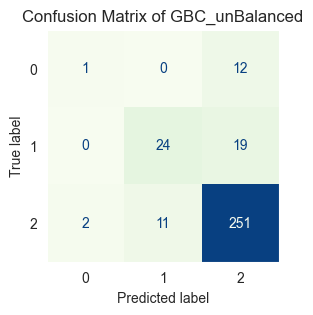

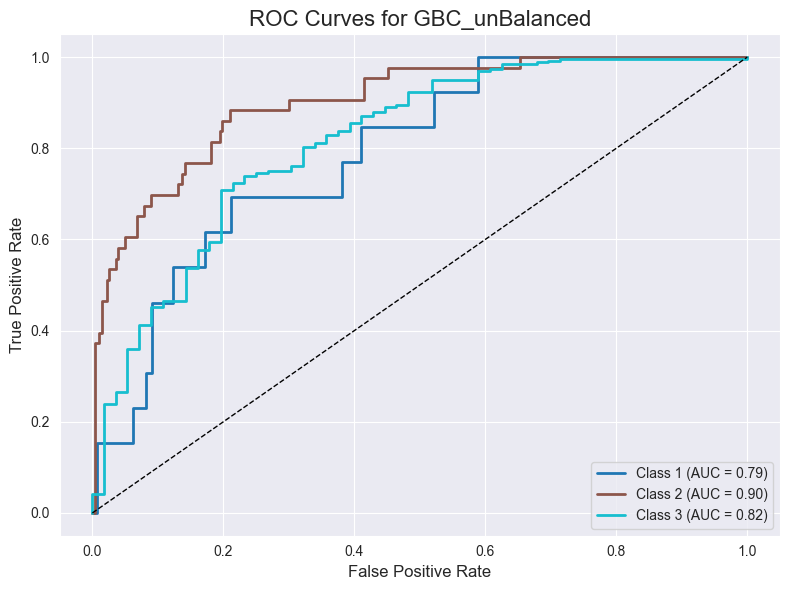

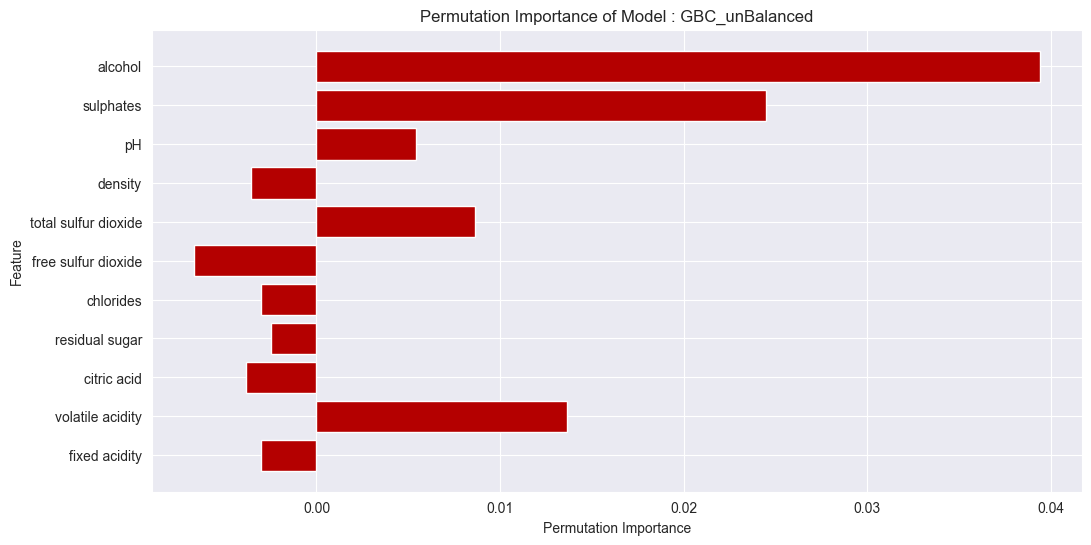


=== GBC_unBalanced ===
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.69      0.56      0.62        43
           2       0.89      0.95      0.92       264

    accuracy                           0.86       320
   macro avg       0.64      0.53      0.55       320
weighted avg       0.84      0.86      0.85       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
GBC_unBalanced,0.55,0.86,0.64,0.53,0.84


In [ ]:
GBC_unBalanced = model_fitter(
    model_name="GBC_unBalanced",
    model_obj=GradientBoostingClassifier(
        loss="log_loss",
        learning_rate=0.2,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=1.0,
        n_estimators=60,
        random_state=33,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["GBC_unBalanced"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

In [ ]:
param_grid_GBC = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    "subsample": [0.8, 1.0],
    "max_features": ["sqrt", "log2"],
}


GBC_grid = grid_fitter(
    model_name="GBC_grid",
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid_GBC,
    target_feature="quality",
    data=df3,
    model_data_splits=model_data_splits,
    standardScaler=True,
    scoring="f1_macro",
)

evaluate_classfications_model(
    model_names=["GBC_unBalanced", "GBC_grid"],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)

Best Score is: 0.5686127120309926
Best Hyperparameters are: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}

=== GBC_unBalanced ===
              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.69      0.56      0.62        43
           2       0.89      0.95      0.92       264

    accuracy                           0.86       320
   macro avg       0.64      0.53      0.55       320
weighted avg       0.84      0.86      0.85       320


=== GBC_grid ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.56      0.63      0.59        30
           2       0.92      0.94      0.93       277

    accuracy                           0.87       320
   macro avg       0.49      0.52      0.51       320
weighted avg       0.84      0.87      0.8

,F1-score,Accuracy,Precision,Recall,roc_auc_score
GBC_unBalanced,0.55,0.86,0.64,0.53,0.84
GBC_grid,0.51,0.87,0.49,0.52,0.83


<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    XGBoost Classifier
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : XGB_unBalanced 



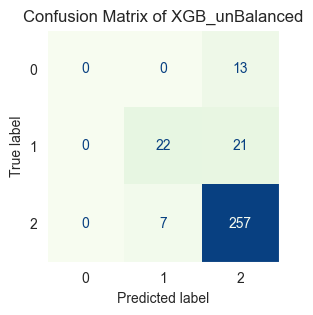

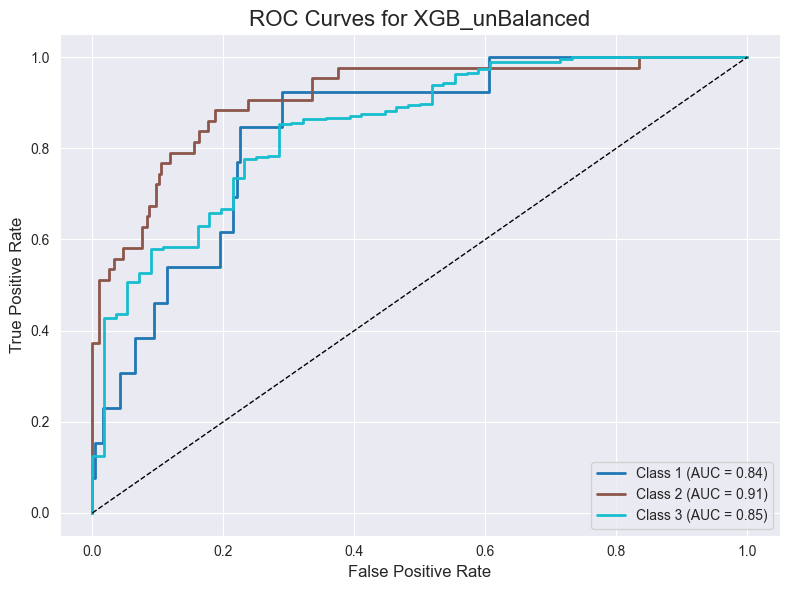

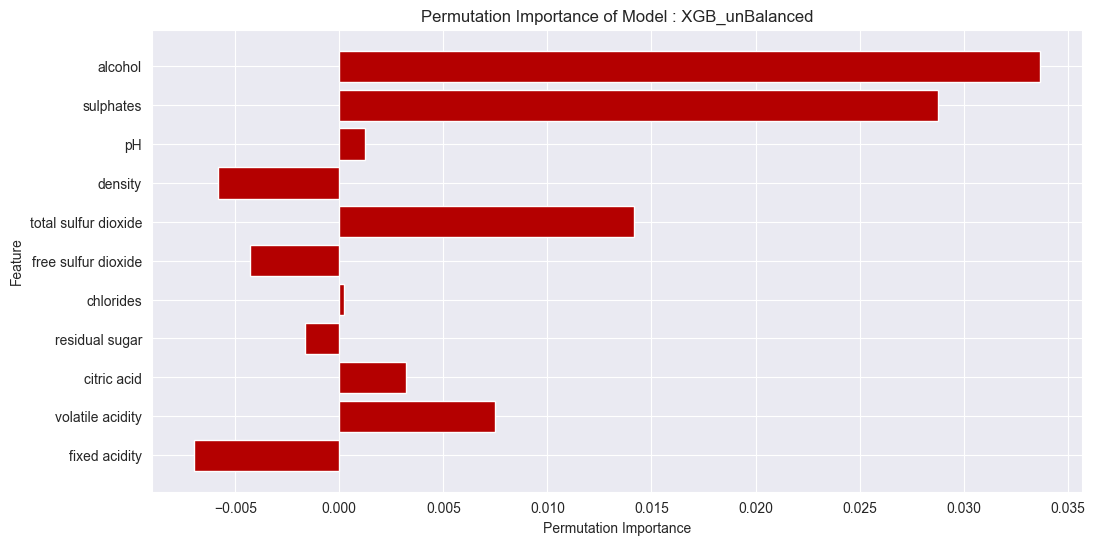


=== XGB_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.76      0.51      0.61        43
           2       0.88      0.97      0.93       264

    accuracy                           0.87       320
   macro avg       0.55      0.50      0.51       320
weighted avg       0.83      0.87      0.85       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
XGB_unBalanced,0.51,0.87,0.55,0.50,0.87


In [ ]:
XGB_unBalanced = model_fitter(
    model_name="XGB_unBalanced",
    model_obj=XGBClassifier(
        booster="gbtree",
        gamma=0.09,
        learning_rate=0.15,
        n_estimators=200,
        max_depth=13,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",   
        num_class=3,  
        random_state=33,
        use_label_encoder=False,   
        eval_metric="mlogloss",   
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["XGB_unBalanced"], model_data_splits=model_data_splits, multi_class=True
)

<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
    Light Gradient Boosting
</h1>


X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LGB_unBalanced 

Before SMOTE:
quality
2    0.824863
1    0.136044
0    0.039093
Name: proportion, dtype: float64 

After SMOTE:
quality
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64 

X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LGB_SMOTE 



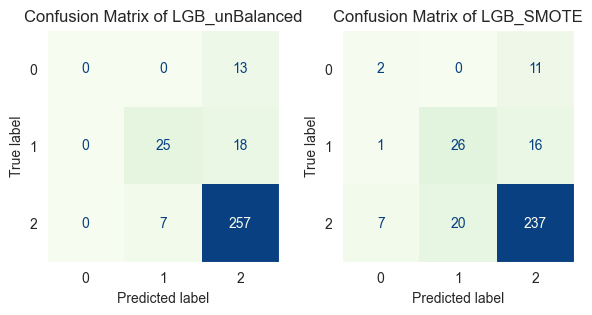

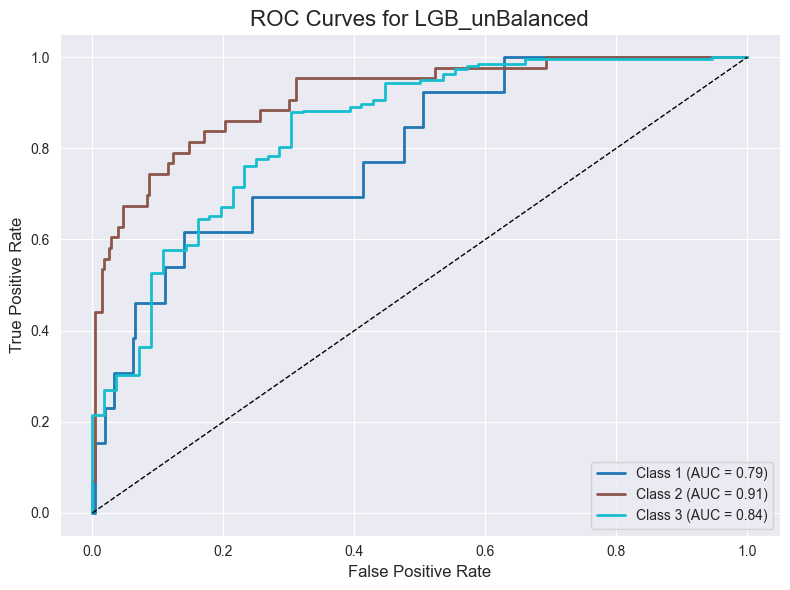

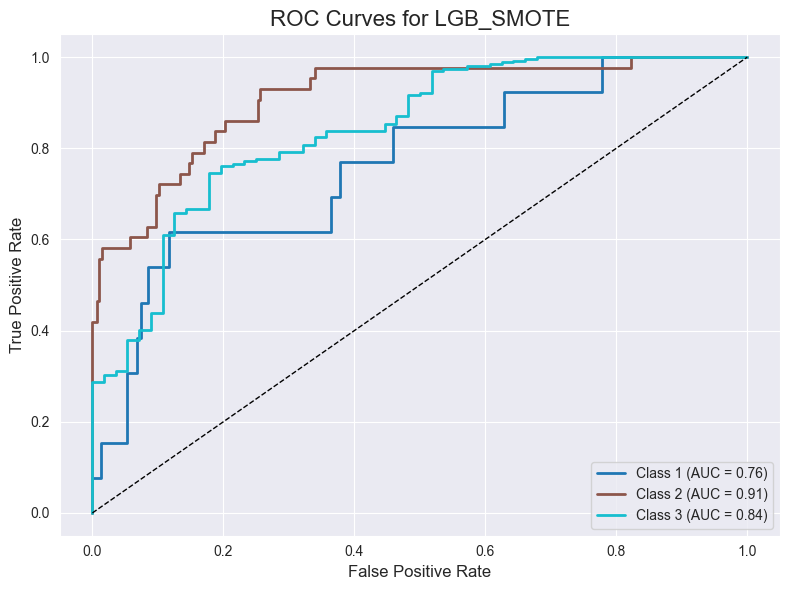

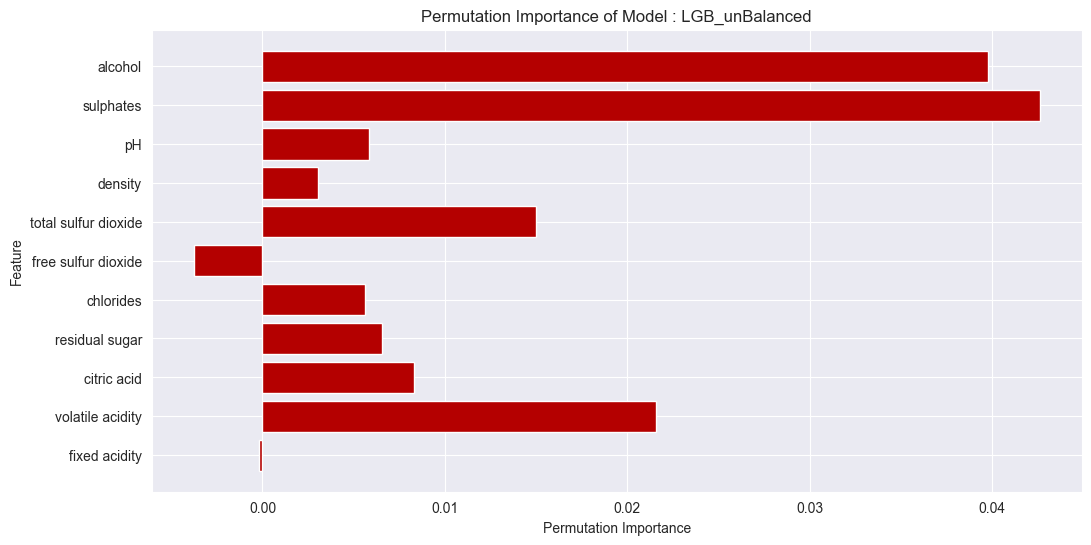

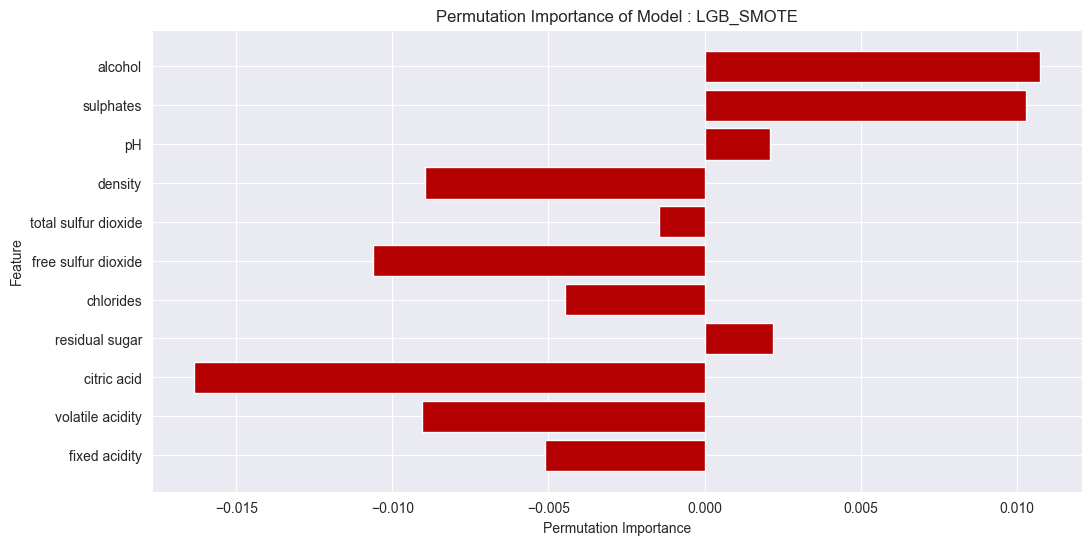


=== LGB_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.78      0.58      0.67        43
           2       0.89      0.97      0.93       264

    accuracy                           0.88       320
   macro avg       0.56      0.52      0.53       320
weighted avg       0.84      0.88      0.86       320


=== LGB_SMOTE ===
              precision    recall  f1-score   support

           0       0.20      0.15      0.17        13
           1       0.57      0.60      0.58        43
           2       0.90      0.90      0.90       264

    accuracy                           0.83       320
   macro avg       0.55      0.55      0.55       320
weighted avg       0.82      0.83      0.83       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
LGB_SMOTE,0.55,0.83,0.55,0.55,0.84
LGB_unBalanced,0.53,0.88,0.56,0.52,0.85


In [ ]:
LGB_unBalanced = model_fitter(
    model_name="LGB_unBalanced",
    model_obj=lgbm.LGBMClassifier(
        boosting_type="gbdt",
        learning_rate=0.1,
        n_estimators=110,
        max_depth=15,
        num_leaves=40,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.1,
        random_state=33,
        verbose=-1,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)
LGB_SMOTE = model_fitter(
    model_name="LGB_SMOTE",
    model_obj=lgbm.LGBMClassifier(
        boosting_type="gbdt",
        learning_rate=0.1,
        n_estimators=110,
        max_depth=15,
        num_leaves=40,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.1,
        random_state=33,
        verbose=-1,
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,Smote=True
)

evaluate_classfications_model(
    model_names=["LGB_unBalanced","LGB_SMOTE"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

<a id="ml"></a>

<h1 style="
    background-color: #354f52;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
   CatBoost Classifier
</h1>


0:	learn: 0.9881071	total: 118ms	remaining: 58.9s
100:	learn: 0.2698545	total: 316ms	remaining: 1.25s
200:	learn: 0.1828981	total: 517ms	remaining: 769ms
300:	learn: 0.1296239	total: 707ms	remaining: 467ms
400:	learn: 0.0984841	total: 901ms	remaining: 222ms
499:	learn: 0.0759821	total: 1.09s	remaining: 0us
X_train: (1279, 11)
X_test: (320, 11)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : CAT_unBalanced 



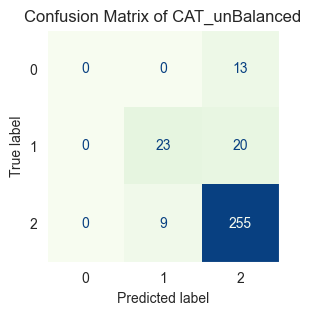

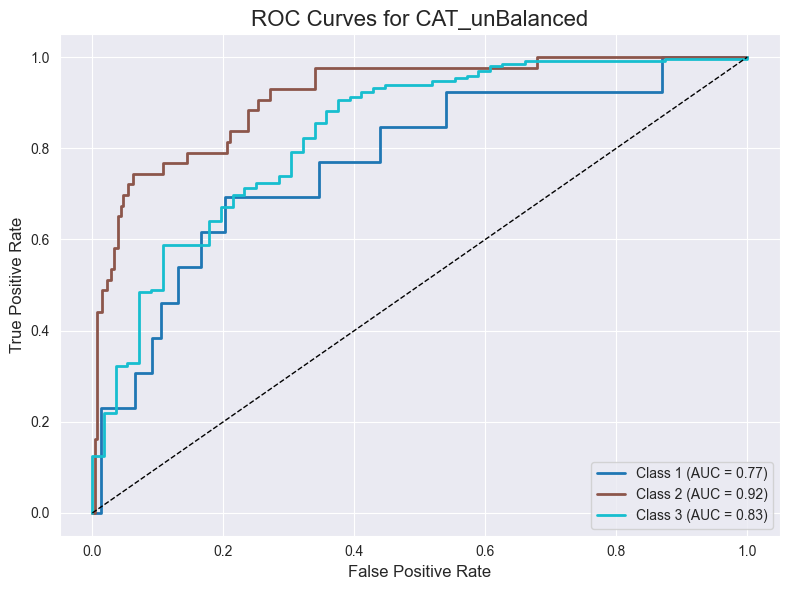

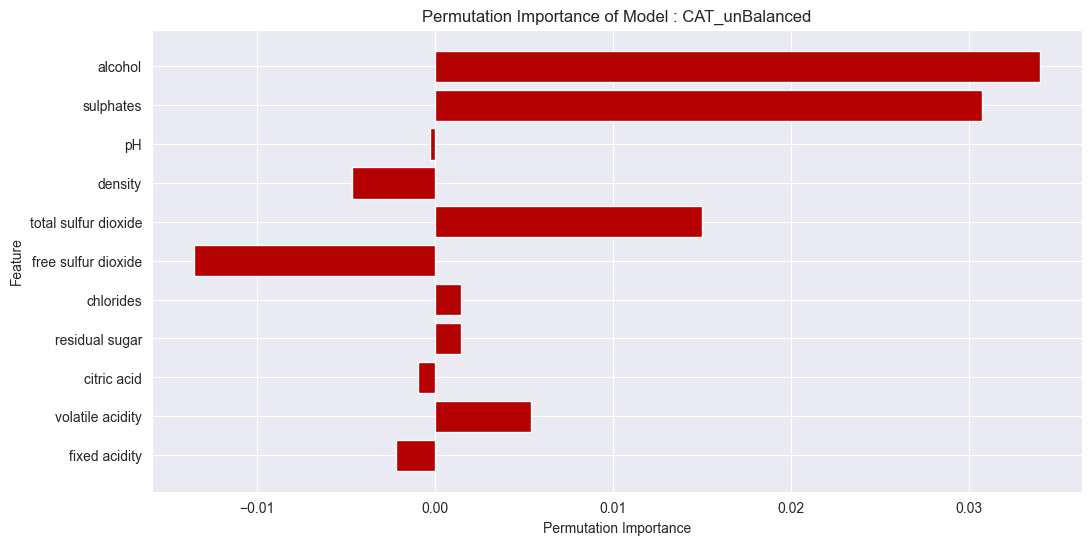


=== CAT_unBalanced ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.72      0.53      0.61        43
           2       0.89      0.97      0.92       264

    accuracy                           0.87       320
   macro avg       0.53      0.50      0.51       320
weighted avg       0.83      0.87      0.84       320


🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
CAT_unBalanced,0.51,0.87,0.53,0.50,0.84


In [ ]:
CAT_unBalanced = model_fitter(
    model_name="CAT_unBalanced",
    model_obj=CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=6, random_seed=33, verbose=100
    ),
    data=df3,
    model_data_splits=model_data_splits,
    target_feature="quality",
    standardScaler=True,
    stratify=True,
)

evaluate_classfications_model(
    model_names=["CAT_unBalanced"],
    model_data_splits=model_data_splits,
    multi_class=True,
)

<a id="ml"></a>

<h1 style="
    background-color:#85182A;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
 First Conclusion
</h1>


In [ ]:
evaluate_classfications_model(
    model_names=[
        "LG_unSMOTE",
        "LG_SMOTE",
        "LG_unSMOTE_balanced",
        "LG_grid",
        "DT_unBalanced",
        "DT_grid",
        "RF_unBalanced",
        "RF_Balanced",
        "RF_grid",
        "SVC_unBalanced",
        "SVC_grid",
        "KNN_unBalanced",
        "KNN_grid",
        "GBC_unBalanced",
        "GBC_grid",
        "XGB_unBalanced",
        "CAT_unBalanced",
        "LGB_unBalanced",
    ],
    model_data_splits=model_data_splits,
    multi_class=True,
    confusionMatrixDisplay=False,
    Permutation_importance=False,
    ROC_curve=False,
)


=== LG_unSMOTE ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.67      0.37      0.48        43
           2       0.86      0.97      0.91       264

    accuracy                           0.85       320
   macro avg       0.51      0.45      0.46       320
weighted avg       0.80      0.85      0.82       320


=== LG_SMOTE ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.41      0.84      0.55        43
           2       0.95      0.58      0.72       264

    accuracy                           0.62       320
   macro avg       0.50      0.73      0.50       320
weighted avg       0.85      0.62      0.68       320


=== LG_unSMOTE_balanced ===
              precision    recall  f1-score   support

           0       0.14      0.77      0.24        13
           1       0.40      0.84      0.54        43
        

,F1-score,Accuracy,Precision,Recall,roc_auc_score
GBC_unBalanced,0.55,0.86,0.64,0.53,0.84
RF_unBalanced,0.54,0.89,0.58,0.51,0.87
LGB_unBalanced,0.53,0.88,0.56,0.52,0.85
DT_unBalanced,0.53,0.80,0.52,0.54,0.67
KNN_grid,0.53,0.88,0.50,0.57,0.78
GBC_grid,0.51,0.87,0.49,0.52,0.83
CAT_unBalanced,0.51,0.87,0.53,0.50,0.84
XGB_unBalanced,0.51,0.87,0.55,0.50,0.87
RF_Balanced,0.51,0.87,0.55,0.49,0.85
KNN_unBalanced,0.51,0.88,0.56,0.49,0.85


<a id="ml"></a>

<h1 style="
    background-color:#85482A;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
 Feature Engineering
</h1>


In [9]:
df4 = df3.copy()

# High VIF and Low Correlating with Target
drop_cols = ["fixed acidity", "density", "citric acid", "pH"]
df4.drop(columns=drop_cols, inplace=True)
df4

,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,0.700,1.9,0.076,11.0,34.0,0.56,9.4,2
1,0.880,2.6,0.098,25.0,67.0,0.68,9.8,2
2,0.760,2.3,0.092,15.0,54.0,0.65,9.8,2
3,0.280,1.9,0.075,17.0,60.0,0.58,9.8,2
4,0.700,1.9,0.076,11.0,34.0,0.56,9.4,2
...,...,...,...,...,...,...,...,...
1594,0.600,2.0,0.090,32.0,44.0,0.58,10.5,2
1595,0.550,2.2,0.062,39.0,51.0,0.76,11.2,2
1596,0.510,2.3,0.076,29.0,40.0,0.75,11.0,2
1597,0.645,2.0,0.075,32.0,44.0,0.71,10.2,2


In [11]:
model_objects = [
    (
        LogisticRegression(class_weight="balanced", random_state=42),
        LogisticRegression(random_state=42),
    ),  # LG
    (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        RandomForestClassifier(random_state=42),
    ),  # RF
    (
        SVC(class_weight="balanced", probability=True, random_state=42),
        SVC(probability=True, random_state=42),
    ),  # SVC
    (
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        DecisionTreeClassifier(random_state=42),
    ),  # DT
    (KNeighborsClassifier(), KNeighborsClassifier()),  # KNN
    (
        GradientBoostingClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
    ),  # GBC
    (
        XGBClassifier(verbosity=0, use_label_encoder=False, random_state=42),
        XGBClassifier(verbosity=0, use_label_encoder=False, random_state=42),
    ),  # XGB
    (
        lgbm.LGBMClassifier(class_weight="balanced", random_state=42),
        lgbm.LGBMClassifier(random_state=42),
    ),  # LGB
    (
        CatBoostClassifier(auto_class_weights="Balanced", verbose=0, random_state=42),
        CatBoostClassifier(verbose=0, random_state=42),
    ),  # CAT
]
model_names = [
    ("LG_Balanced", "LG_SMOTE"),
    ("RF_Balanced", "RF_SMOTE"),
    ("SVC_Balanced", "SVC_SMOTE"),
    ("DT_Balanced", "DT_SMOTE"),
    ("KNN_Balanced", "KNN_SMOTE"),
    ("GBC_Balanced", "GBC_SMOTE"),
    ("XGB_Balanced", "XGB_SMOTE"),
    ("LGB_Balanced", "LGB_SMOTE"),
    ("CAT_Balanced", "CAT_SMOTE"),
]

In [ ]:
model_data_splits_2 = {}
for (M1, M2), (N1, N2) in zip(model_objects, model_names):
    model_fitter(
        model_name=N1,
        model_obj=M1,
        data=df4,
        model_data_splits=model_data_splits_2,
        target_feature="quality",
        standardScaler=True,
        stratify=True,
    )
    model_fitter(
        model_name=N2,
        model_obj=M2,
        data=df4,
        model_data_splits=model_data_splits_2,
        target_feature="quality",
        standardScaler=True,
        stratify=True,
        Smote=True
    )


X_train: (1279, 7)
X_test: (320, 7)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LG_Balanced 

Before SMOTE:
quality
2    0.824863
1    0.136044
0    0.039093
Name: proportion, dtype: float64 

After SMOTE:
quality
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64 

X_train: (1279, 7)
X_test: (320, 7)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : LG_SMOTE 

X_train: (1279, 7)
X_test: (320, 7)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : RF_Balanced 

Before SMOTE:
quality
2    0.824863
1    0.136044
0    0.039093
Name: proportion, dtype: float64 

After SMOTE:
quality
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64 

X_train: (1279, 7)
X_test: (320, 7)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : RF_SMOTE 

X_train: (1279, 7)
X_test: (320, 7)
y_train: (1279,)
y_test: (320,)
The Name of Fitted Model : SVC_Balanced 

Before SMOTE:
quality
2    0.824863
1    0.136044
0    0.039093
Na

In [14]:
model_names_list = [name for pair in model_names for name in pair]
model_names_list

['LG_Balanced',
 'LG_SMOTE',
 'RF_Balanced',
 'RF_SMOTE',
 'SVC_Balanced',
 'SVC_SMOTE',
 'DT_Balanced',
 'DT_SMOTE',
 'KNN_Balanced',
 'KNN_SMOTE',
 'GBC_Balanced',
 'GBC_SMOTE',
 'XGB_Balanced',
 'XGB_SMOTE',
 'LGB_Balanced',
 'LGB_SMOTE',
 'CAT_Balanced',
 'CAT_SMOTE']

<a id="ml"></a>

<h1 style="
    background-color:#85182A;
    background-position: center;
    font-family: 'Times New Roman', serif;
    font-size: 1.5em;
    color: white;
    text-align: center;
    padding: 15px;
    border-radius: 15px 50px;
    border: 1px solid black;
">
 Second Conclusion
</h1>


In [ ]:
evaluate_classfications_model(
    model_names=model_names_list,
    model_data_splits=model_data_splits_2,
    confusionMatrixDisplay=False,
    multi_class=True,
    classifi_report=False,
    ROC_curve=False,
    Permutation_importance=False,
)


=== LG_Balanced ===

=== LG_SMOTE ===

=== RF_Balanced ===

=== RF_SMOTE ===

=== SVC_Balanced ===

=== SVC_SMOTE ===

=== DT_Balanced ===

=== DT_SMOTE ===

=== KNN_Balanced ===

=== KNN_SMOTE ===

=== GBC_Balanced ===

=== GBC_SMOTE ===

=== XGB_Balanced ===

=== XGB_SMOTE ===

=== LGB_Balanced ===

=== LGB_SMOTE ===

=== CAT_Balanced ===

=== CAT_SMOTE ===

🎯 Final Comparison of Models:


,F1-score,Accuracy,Precision,Recall,roc_auc_score
XGB_SMOTE,0.59,0.82,0.57,0.61,0.78
RF_SMOTE,0.57,0.81,0.55,0.60,0.85
LGB_SMOTE,0.57,0.82,0.56,0.57,0.79
CAT_SMOTE,0.56,0.82,0.55,0.58,0.78
CAT_Balanced,0.55,0.82,0.55,0.56,0.81
LGB_Balanced,0.54,0.84,0.56,0.54,0.81
DT_SMOTE,0.54,0.76,0.52,0.61,0.70
RF_Balanced,0.53,0.88,0.57,0.50,0.86
DT_Balanced,0.53,0.81,0.54,0.52,0.65
GBC_Balanced,0.53,0.85,0.58,0.50,0.80
